In [1]:
import numpy as np
from math import pi, sqrt, tanh
import matplotlib.pyplot as plt
from scipy.linalg import block_diag
from os import path

from quimb import *
import time


In [2]:
def Hilbertspace_Zr(N,r):

    states=np.zeros((r**N,N),dtype=int)

    if N>0:
        for i_1 in range(r**N):
            num_str=np.base_repr(i_1,base=r)[::-1]
            for i_2 in range(len(num_str)):
                states[i_1,i_2]=int(num_str[i_2])
    else:
        states=[[0]]
        
    return states

def p_transpose_2(V,Na,Nb):
# partial transpose with respect to subsystem 2
# the basis of NaxNb density matrix is defined by Nb*(i-1)+j,
# i,j=1,2,3 spans the Hilbert space of subsystem 1 and 2 respectively
    U=np.zeros((Na*Nb,Na*Nb), dtype=np.complex128)
    for i_1 in range(Na):
        for i_2 in range(Na):
#             print(V[Nb*i_1:Nb*(i_1+1),Nb*i_2:Nb*(i_2+1)].shape)
            U[Nb*i_1:Nb*(i_1+1),Nb*i_2:Nb*(i_2+1)]=np.transpose(V[Nb*i_1:Nb*(i_1+1),Nb*i_2:Nb*(i_2+1)])

    return U

def vNent_calc(rho,epsilon=1e-9):
    chi0 =np.linalg.eigvalsh(rho)
    chi1=chi0[np.nonzero(np.abs(chi0)>epsilon)]
    chi2=chi1[np.nonzero(np.abs(chi1-1)>epsilon)]
    return -np.sum(chi2*np.log(chi2))


In [2]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute
from qiskit.tools.visualization import circuit_drawer
from qiskit.quantum_info import state_fidelity
from qiskit import BasicAer

r = 2
La = 3
Lb = 3
Lc = 3
Ld = 1
Lt = La+Lb+Lc+Ld
q = QuantumRegister(Lt)

Niter= 100
Nrep = 1

i_a = range(La)
i_b = range(La,La+Lb)
i_c = range(La+Lb,La+Lb+Lc)
i_d = range(La+Lb+Lc,Lt)

ln_ab=np.zeros(Nrep)
ln_ac=np.zeros(Nrep)
ln_bc=np.zeros(Nrep)
ln_ad=np.zeros(Nrep)
ln_bd=np.zeros(Nrep)
ln_cd=np.zeros(Nrep)
ln_ab_d=np.zeros(Nrep)
ln_ac_d=np.zeros(Nrep)
ln_bc_d=np.zeros(Nrep)
ln_ab_c=np.zeros(Nrep)

mi_ab=np.zeros(Nrep)
mi_ac=np.zeros(Nrep)
mi_bc=np.zeros(Nrep)
mi_ad=np.zeros(Nrep)
mi_bd=np.zeros(Nrep)
mi_cd=np.zeros(Nrep)
mi_ab_d=np.zeros(Nrep)
mi_ac_d=np.zeros(Nrep)
mi_bc_d=np.zeros(Nrep)
mi_ab_c=np.zeros(Nrep)
ent_a=np.zeros(Nrep)
ent_b=np.zeros(Nrep)
ent_c=np.zeros(Nrep)
ent_d=np.zeros(Nrep)

LN = np.zeros(Nrep)
EE = np.zeros(Nrep)
for i_r in range(Nrep):
    print(i_r)
    qc = QuantumCircuit(q)
    arr = np.arange(Lt)
    for i in range(Niter):
        np.random.shuffle(arr)
        for n in range(int(Lt/2)):
            if np.random.rand()<1/2:
                if np.random.rand()<1/2:
                    qc.s(arr[2*n]) # pi/2 phase gate
                else:
                    qc.h(arr[2*n]) # hadamard
            else:
                if np.random.rand()<1/2:
                    qc.cx(arr[2*n],arr[2*n+1])
                else:    
                    qc.swap(arr[2*n],arr[2*n+1])

    #     qc.s(2)
    #     qc.h(0)
    #     qc.cx(0, 1)

    backend = BasicAer.get_backend('statevector_simulator')
    job = execute(qc, backend)
    psi = job.result().get_statevector(qc)

    ln_ab[i_r]= logneg_subsys(psi,dims=[r]*(Lt),sysa=i_a,sysb=i_b)
    ln_ac[i_r]= logneg_subsys(psi,dims=[r]*(Lt),sysa=i_a,sysb=i_c)
    ln_bc[i_r]= logneg_subsys(psi,dims=[r]*(Lt),sysa=i_b,sysb=i_c)
    ln_ad[i_r]= logneg_subsys(psi,dims=[r]*(Lt),sysa=i_d,sysb=i_a)
    ln_bd[i_r]= logneg_subsys(psi,dims=[r]*(Lt),sysa=i_d,sysb=i_b)
    ln_cd[i_r]= logneg_subsys(psi,dims=[r]*(Lt),sysa=i_d,sysb=i_c)
    ln_ab_c[i_r]= logneg_subsys(psi,dims=[r]*(Lt),sysa=i_c,sysb=np.concatenate((i_a,i_b)))
    ln_ab_d[i_r]= logneg_subsys(psi,dims=[r]*(Lt),sysa=i_d,sysb=np.concatenate((i_a,i_b)))
    ln_bc_d[i_r]= logneg_subsys(psi,dims=[r]*(Lt),sysa=i_d,sysb=np.concatenate((i_b,i_c)))
    ln_ac_d[i_r]= logneg_subsys(psi,dims=[r]*(Lt),sysa=i_d,sysb=np.concatenate((i_a,i_c)))

    
    mi_ab[i_r]= mutinf_subsys(psi,dims=[r]*(Lt),sysa=i_a,sysb=i_b)
    mi_ac[i_r]= mutinf_subsys(psi,dims=[r]*(Lt),sysa=i_a,sysb=i_c)
    mi_bc[i_r]= mutinf_subsys(psi,dims=[r]*(Lt),sysa=i_b,sysb=i_c)
    mi_ad[i_r]= mutinf_subsys(psi,dims=[r]*(Lt),sysa=i_d,sysb=i_a)
    mi_bd[i_r]= mutinf_subsys(psi,dims=[r]*(Lt),sysa=i_d,sysb=i_b)
    mi_cd[i_r]= mutinf_subsys(psi,dims=[r]*(Lt),sysa=i_d,sysb=i_c)
    mi_ab_c[i_r]= mutinf_subsys(psi,dims=[r]*(Lt),sysa=i_c,sysb=np.concatenate((i_a,i_b)))
    mi_ab_d[i_r]= mutinf_subsys(psi,dims=[r]*(Lt),sysa=i_d,sysb=np.concatenate((i_a,i_b)))
    mi_bc_d[i_r]= mutinf_subsys(psi,dims=[r]*(Lt),sysa=i_d,sysb=np.concatenate((i_b,i_c)))
    mi_ac_d[i_r]= mutinf_subsys(psi,dims=[r]*(Lt),sysa=i_d,sysb=np.concatenate((i_a,i_c)))

    ent_a[i_r] = entropy_subsys(psi,dims=[r]*(Lt),sysa=i_a)
    ent_b[i_r] = entropy_subsys(psi,dims=[r]*(Lt),sysa=i_b)
    ent_c[i_r] = entropy_subsys(psi,dims=[r]*(Lt),sysa=i_c)
    ent_d[i_r] = entropy_subsys(psi,dims=[r]*(Lt),sysa=i_d)

print("A-B: %.1f, %.1f" % (np.mean(ln_ab),np.mean(mi_ab)))
print("B-C: %.1f, %.1f" % (np.mean(ln_bc),np.mean(mi_bc)))
print("A-C: %.1f, %.1f" % (np.mean(ln_ac),np.mean(mi_ac)))
print("AB-C: %.1f" % (np.mean(ln_ab_c)))
print("LN D-one: %.1f, %.1f, %.1f" % (np.mean(ln_ad),np.mean(ln_bd),np.mean(ln_cd)))
print("MI D-one: %.1f, %.1f, %.1f" % (np.mean(mi_ad),np.mean(mi_bd),np.mean(mi_cd)))
print("LN D-two: %.1f, %.1f, %.1f" % (np.mean(ln_ab_d),np.mean(ln_bc_d),np.mean(ln_ac_d)))
print("mi D-two: %.1f, %.1f, %.1f" % (np.mean(mi_ab_d),np.mean(mi_bc_d),np.mean(mi_ac_d)))
print("ent A: %.1f" % (np.mean(ent_a)))
print("ent B: %.1f" % (np.mean(ent_b)))
print("ent C: %.1f" % (np.mean(ent_c)))
print("ent D: %.1f" % (np.mean(ent_d)))


0
A-B: 1.0, 2.0
B-C: 1.0, 3.0
A-C: 1.0, 2.0
AB-C: 3.0
LN D-one: 0.0, 0.0, 0.0
MI D-one: 1.0, 0.0, 0.0
LN D-two: 1.0, 0.0, 1.0
mi D-two: 2.0, 1.0, 2.0
ent A: 3.0
ent B: 3.0
ent C: 3.0
ent D: 1.0


In [70]:
%config InlineBackend.figure_formats = ['svg']

import random
import quimb as qu
import quimb.tensor as qtn

N = 10
circ = qtn.Circuit(N)

# randomly permute the order of qubits
regs = list(range(N))
random.shuffle(regs)

# hamadard on one of the qubits
circ.apply_gate('H', regs[0])

# chain of cnots to generate GHZ-state
for i in range(N - 1):
    circ.apply_gate('CNOT', regs[i], regs[i + 1])

# # sample it once
# for b in circ.sample(1):
#     print(b)
circ

<Circuit(n=10, num_gates=10, gate_opts={'contract': 'auto-split-gate', 'propagate_tags': 'register'})>

In [71]:
# 10 qubits and tag the initial wavefunction tensors
circ = qtn.Circuit(N=10)

# initial layer of hadamards
for i in range(10):
    circ.apply_gate('H', i, gate_round=0)

# 8 rounds of entangling gates
for r in range(1, 9):

    # even pairs
    for i in range(0, 10, 2):
        circ.apply_gate('CNOT', i, i + 1, gate_round=r)

    # Y-rotations
    for i in range(10):
        circ.apply_gate('RZ', 1.234, i, gate_round=r)

    # odd pairs
    for i in range(1, 9, 2):
        circ.apply_gate('CZ', i, i + 1, gate_round=r)

    # X-rotations
    for i in range(10):
        circ.apply_gate('RX', 1.234, i, gate_round=r)

# final layer of hadamards
for i in range(10):
    circ.apply_gate('H', i, gate_round=r + 1)

circ.partial_trace((4, 5)).round(3)


array([[ 0.252-0.j   ,  0.013+0.011j, -0.019+0.007j, -0.016-0.003j],
       [ 0.013-0.011j,  0.255-0.j   ,  0.013+0.014j,  0.02 +0.017j],
       [-0.019-0.007j,  0.013-0.014j,  0.254+0.j   ,  0.019+0.012j],
       [-0.016+0.003j,  0.02 -0.017j,  0.019-0.012j,  0.239+0.j   ]])

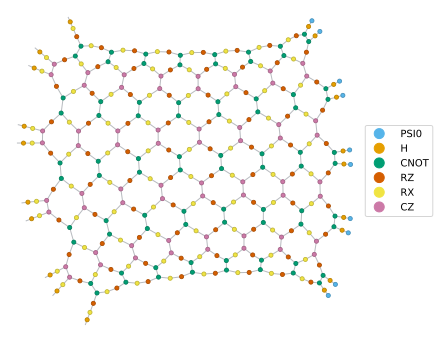

In [73]:
circ.psi.draw(color=['PSI0', 'H', 'CNOT', 'RZ', 'RX', 'CZ'])


In [1]:
from qiskit import QuantumCircuit

qc = QuantumCircuit(5)
qc.h(0)
qc.cx(0, range(1, 5))
qc.measure_all()

In [4]:
Nrep=1000
r=2 # local Hilbert space dim
symm=1

L = 4
psi = np.zeros(2**L)
psi[0] = 1

H = np.array([[1,1],[1,-1]])/sqrt(2)
P = np.array([[1,0],[0,1j]])

i1 = 1
i2 = 3
CNOT =  


In [8]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit

qr = QuantumRegister(3, 'q')
anc = QuantumRegister(1, 'ancilla')
cr = ClassicalRegister(3, 'c')
qc = QuantumCircuit(qr, anc, cr)

qc.x(anc[0])
qc.h(anc[0])
qc.h(qr[0:3])
qc.cx(qr[0:3], anc[0])
qc.h(qr[0:3])
qc.barrier(qr)
qc.measure(qr, cr)

qc.draw()

┌───┐          ┌───┐           ░ ┌─┐      
      q_0: ┤ H ├───────■──┤ H ├───────────░─┤M├──────
           ├───┤       │  └───┘┌───┐      ░ └╥┘┌─┐   
      q_1: ┤ H ├───────┼────■──┤ H ├──────░──╫─┤M├───
           ├───┤       │    │  └───┘┌───┐ ░  ║ └╥┘┌─┐
      q_2: ┤ H ├───────┼────┼────■──┤ H ├─░──╫──╫─┤M├
           ├───┤┌───┐┌─┴─┐┌─┴─┐┌─┴─┐└───┘ ░  ║  ║ └╥┘
ancilla_0: ┤ X ├┤ H ├┤ X ├┤ X ├┤ X ├─────────╫──╫──╫─
           └───┘└───┘└───┘└───┘└───┘         ║  ║  ║ 
      c: 3/══════════════════════════════════╩══╩══╩═
                                             0  1  2

In [9]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute
from qiskit.tools.visualization import circuit_drawer
from qiskit.quantum_info import state_fidelity
from qiskit import BasicAer

L = 10
q = QuantumRegister(L)

Niter= 100

Nrep = 100
LN = np.zeros(Nrep)
EE = np.zeros(Nrep)
for i_r in range(Nrep):
    print(i_r)
    qc = QuantumCircuit(q)
    arr = np.arange(L)
    for i in range(Niter):
        np.random.shuffle(arr)
        for n in range(int(L/2)):
            if np.random.rand()<1/2:
                if np.random.rand()<1/2:
                    qc.s(arr[2*n]) # pi/2 phase gate
                else:
                    qc.h(arr[2*n]) # hadamard
            else:
                if np.random.rand()<1/2:
                    qc.cx(arr[2*n],arr[2*n+1])
                else:    
                    qc.swap(arr[2*n],arr[2*n+1])

    #     qc.s(2)
    #     qc.h(0)
    #     qc.cx(0, 1)

    backend = BasicAer.get_backend('statevector_simulator')
    job = execute(qc, backend)
    qc_state = job.result().get_statevector(qc)
    # print(qc_state)
    # qc.draw()      

    La = 1
    Lb = 6
    LN[i_r]=logneg_subsys(qc_state,dims=[2]*L,sysa=range(La),sysb=range(La,La+Lb))
    EE[i_r]=entropy_subsys(qc_state, dims=[2]*L, sysa=range(La))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


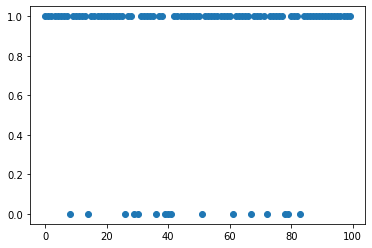

In [10]:
plt.plot(LN,"o")

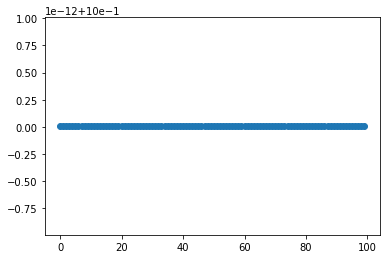

In [11]:
plt.plot(EE,"o")

In [3]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute
from qiskit.tools.visualization import circuit_drawer
from qiskit.quantum_info import state_fidelity
from qiskit import BasicAer

L = 6
q = QuantumRegister(L)

Niter= 8

Nrep = 1
LN = np.zeros(Nrep)
EE = np.zeros(Nrep)
qc = QuantumCircuit(q)
arr = np.arange(L)
for i in range(Niter):
    np.random.shuffle(arr)
    for n in range(int(L/2)):
        if np.random.rand()<1/2:
            if np.random.rand()<1/2:
                qc.s(arr[2*n]) # pi/2 phase gate
            else:
                qc.h(arr[2*n]) # hadamard
        else:
            if np.random.rand()<1/2:
                qc.cx(arr[2*n],arr[2*n+1])
            else:    
                qc.swap(arr[2*n],arr[2*n+1])

#     qc.s(2)
#     qc.h(0)
#     qc.cx(0, 1)

    backend = BasicAer.get_backend('statevector_simulator')
    job = execute(qc, backend)
    qc_state = job.result().get_statevector(qc)
print(qc_state)
# qc.draw()      

#     La = 1
#     Lb = 6
#     LN[i_r]=logneg_subsys(qc_state,dims=[2]*L,sysa=range(La),sysb=range(La,La+Lb))
#     EE[i_r]=entropy_subsys(qc_state, dims=[2]*L, sysa=range(La))

[ 0.25-1.5308085e-17j  0.25-1.5308085e-17j  0.  +0.0000000e+00j
  0.  +0.0000000e+00j  0.25-1.5308085e-17j  0.25-1.5308085e-17j
  0.  +0.0000000e+00j  0.  +0.0000000e+00j  0.  +0.0000000e+00j
  0.  +0.0000000e+00j  0.  +0.0000000e+00j  0.  +0.0000000e+00j
  0.  +0.0000000e+00j  0.  +0.0000000e+00j  0.  +0.0000000e+00j
  0.  +0.0000000e+00j  0.  +0.0000000e+00j  0.  +0.0000000e+00j
  0.  +0.0000000e+00j  0.  +0.0000000e+00j  0.  +0.0000000e+00j
  0.  +0.0000000e+00j  0.  +0.0000000e+00j  0.  +0.0000000e+00j
  0.  +0.0000000e+00j  0.  +0.0000000e+00j  0.25-1.5308085e-17j
  0.25-1.5308085e-17j  0.  +0.0000000e+00j  0.  +0.0000000e+00j
  0.25-1.5308085e-17j  0.25-1.5308085e-17j  0.25-4.5924255e-17j
  0.25-4.5924255e-17j  0.  +0.0000000e+00j  0.  +0.0000000e+00j
 -0.25+4.5924255e-17j -0.25+4.5924255e-17j  0.  +0.0000000e+00j
  0.  +0.0000000e+00j  0.  +0.0000000e+00j  0.  +0.0000000e+00j
  0.  +0.0000000e+00j  0.  +0.0000000e+00j  0.  +0.0000000e+00j
  0.  +0.0000000e+00j  0.  +0.0000000e+0